In [1]:
import os
import shutil
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageOps
from facenet_pytorch import (MTCNN,
                             InceptionResnetV1,
                             fixed_image_standardization,
                             training)
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image

from moviepy.editor import VideoFileClip, ImageSequenceClip
from pydub import AudioSegment

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cqj3jpdx because the default path (/home/jlegara/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-06-06 20:06:54.246659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 20:06:54.355678: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variabl

In [3]:
import os

# Set cache directories for XDG and Hugging Face Hub
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/jlegara/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/msds2023/jlegara/.cache'

In [4]:
import torch

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from moviepy.editor import VideoFileClip

import torch
from facenet_pytorch import (MTCNN)

from transformers import (AutoFeatureExtractor,
                          AutoModelForImageClassification,
                          AutoConfig)
                             
from PIL import Image, ImageDraw

In [6]:
# Load your video
four_sisters_video = 'four_sisters.mp4'
clip = VideoFileClip(four_sisters_video)

In [7]:
vid_fps = clip.fps
print(f"Video fps: {vid_fps}")

# Get the audio
audio = clip.audio

aud_fps = audio.fps
print(f"Audio fps: {aud_fps}")

Video fps: 23.976023976023978
Audio fps: 44100


In [8]:
# Get the audio
audio_data = np.array(audio.to_soundarray(fps=aud_fps))

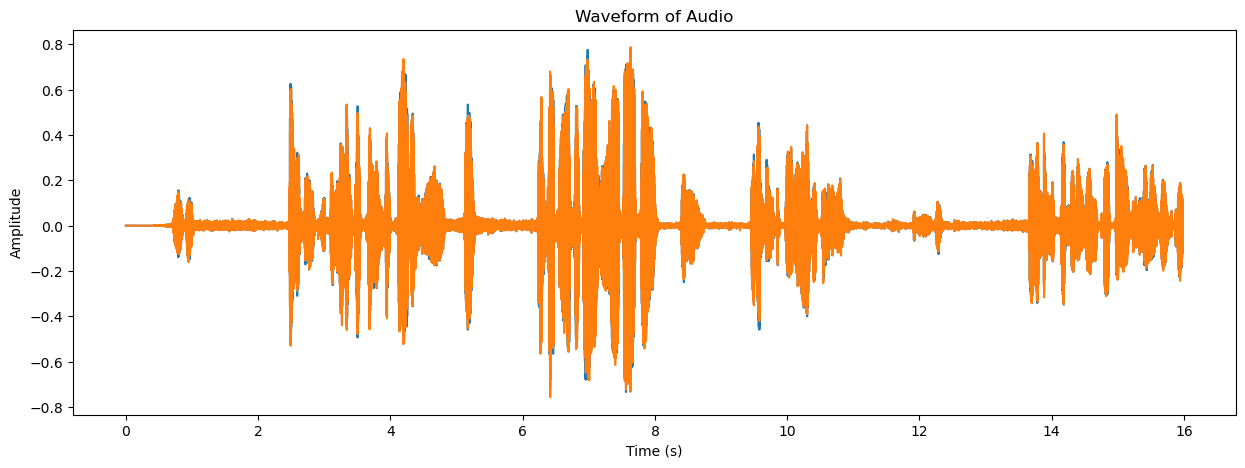

In [9]:
# Create a time variable
time = np.linspace(0., len(audio_data) / audio.fps, num=len(audio_data))

plt.figure(figsize=(15, 5))
plt.plot(time, audio_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio')
plt.show()

In [10]:
# Get the video (as frames)
video = clip.without_audio()
video_data = np.array(list(video.iter_frames()))

In [11]:
video_data.shape

(384, 720, 1280, 3)

In [12]:
def detect_emotions(image):
    """
    Detect emotions from a given image, displays the detected face and the emotion probabilities in a bar plot.

    Parameters:
    image (PIL.Image): The input image.

    Returns:
    PIL.Image: The cropped face from the input image.
    """
    
    # Create a copy of the image to draw on
    temporary = image.copy()

    # Use the MTCNN model to detect faces in the image
    sample = mtcnn.detect(temporary)

    # If a face is detected
    if sample[0] is not None:
        
        # Get the bounding box coordinates of the face
        box = sample[0][0]
        
        # Crop the detected face from the image
        face = temporary.crop(box)

        # Pre-process the cropped face to be fed into the emotion detection model
        inputs = extractor(images=face, return_tensors="pt")

        # Pass the pre-processed face through the model to get emotion predictions
        outputs = model(**inputs)

        # Apply softmax to the logits to get probabilities
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Retrieve the id2label attribute from the configuration
        id2label = AutoConfig.from_pretrained("trpakov/vit-face-expression").id2label

        # Convert probabilities tensor to a Python list
        probabilities = probabilities.detach().numpy().tolist()[0]

        # Map class labels to their probabilities
        class_probabilities = {id2label[i]: prob for i, prob in enumerate(probabilities)}

        # Prepare a figure with 2 subplots: one for the face image, one for the bar plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Display the cropped face in the left subplot
        axs[0].imshow(np.array(face))
        axs[0].axis('off')

        # Create a horizontal bar plot of the emotion probabilities in the right subplot
        sns.barplot(ax=axs[1], y=list(class_probabilities.keys()), x=[prob * 100 for prob in class_probabilities.values()], orient='h')
        axs[1].set_xlabel('Probability (%)')
        axs[1].set_title('Emotion Probabilities')
        axs[1].set_xlim([0, 100])  # Set x-axis limits to show percentages

        # Show the plot
        plt.show()

In [13]:
# Initialize MTCNN model for single face cropping
mtcnn = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=200,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    keep_all=False,
    device=device
)
    
# Load the pre-trained model and feature extractor
extractor = AutoFeatureExtractor.from_pretrained("trpakov/vit-face-expression")
model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

2023-06-06 21:22:50.431301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 21:22:50.544442: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


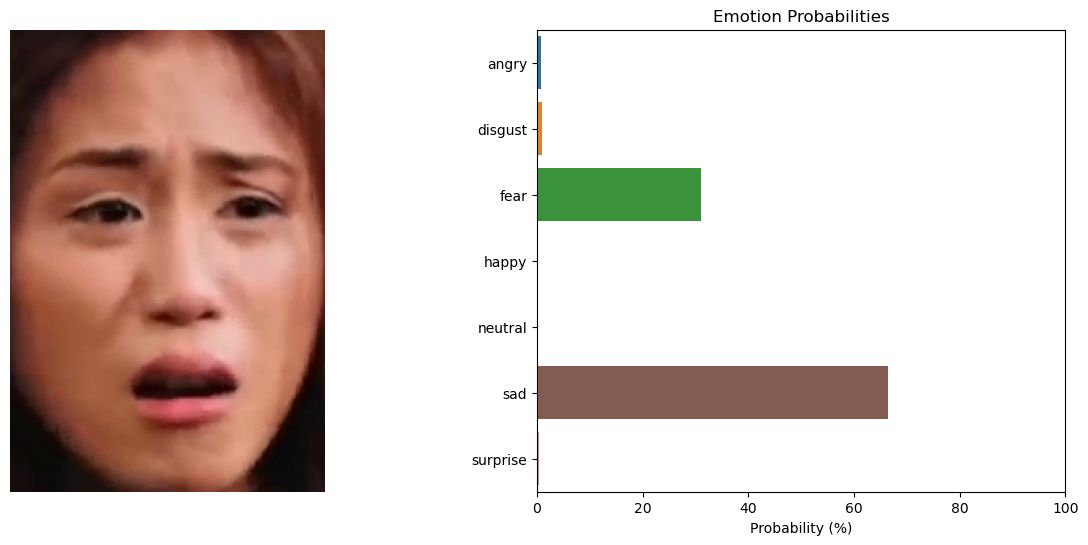

In [14]:
# Choose a frame
frame = video_data[50]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)

detect_emotions(image)

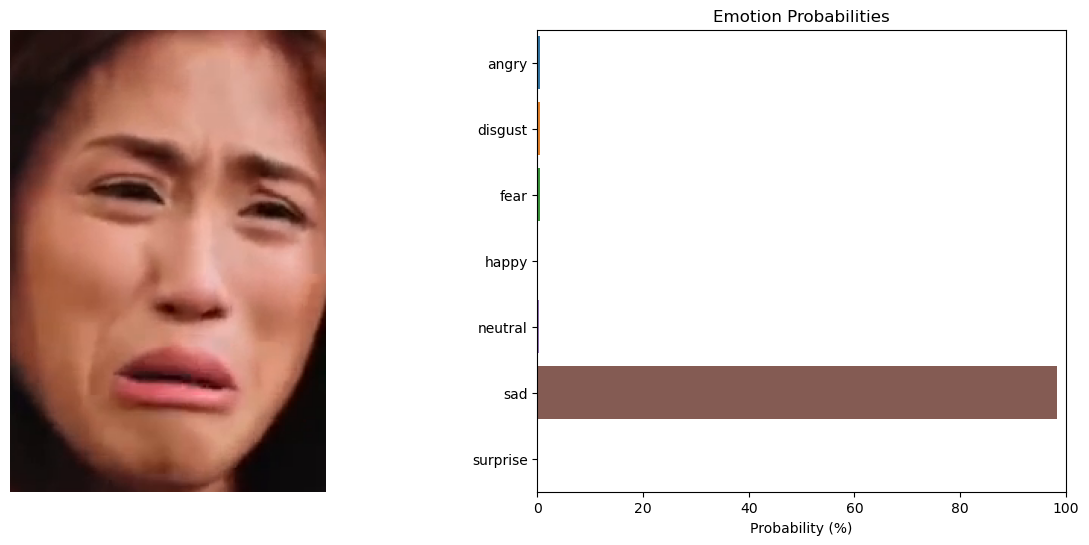

In [15]:
# Choose a frame
frame = video_data[100]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)

detect_emotions(image)

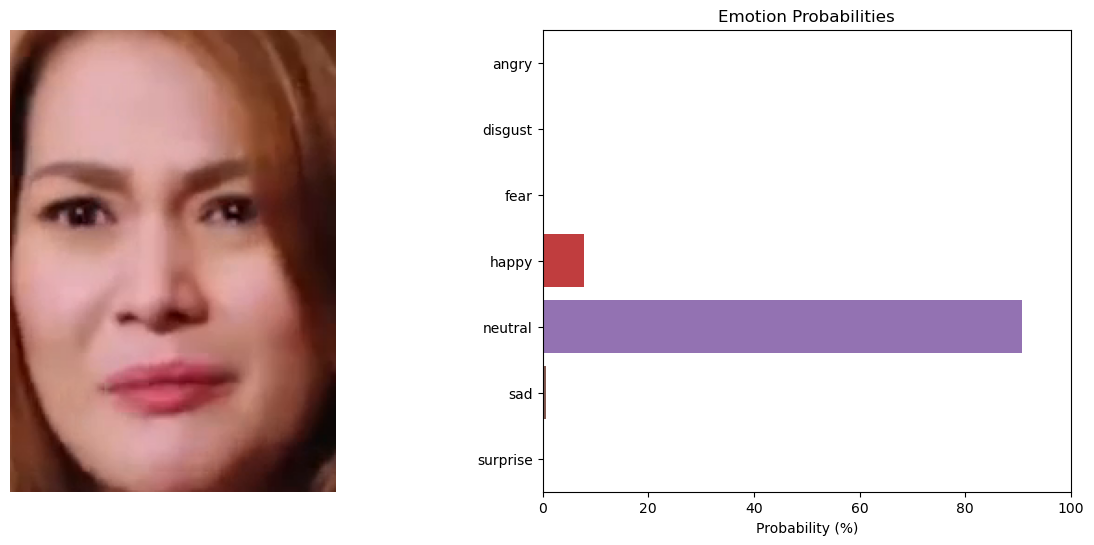

In [16]:
# Choose a frame
frame = video_data[320]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)

detect_emotions(image)

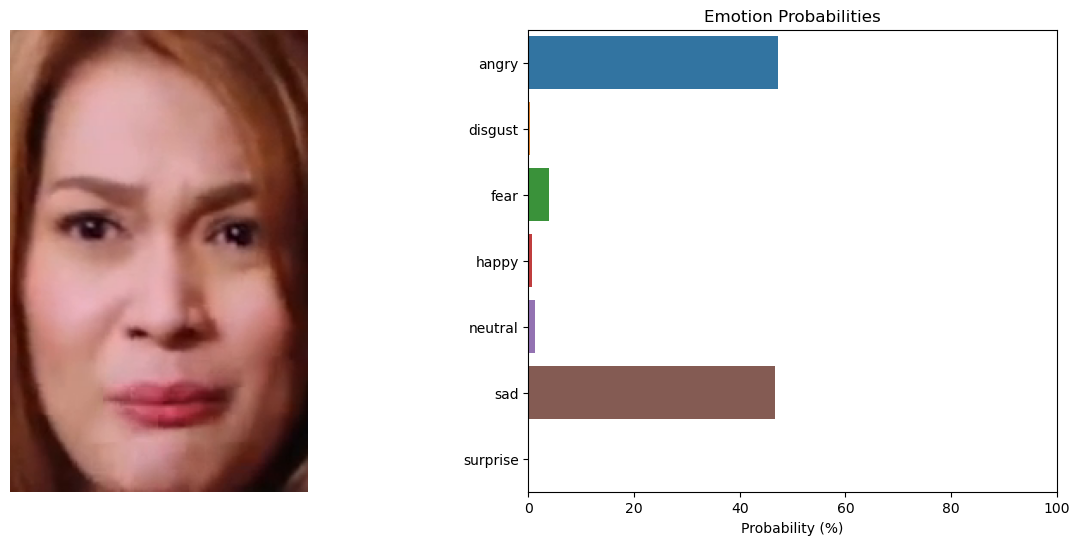

In [17]:
# Choose a frame
frame = video_data[350]

# Convert the frame to a PIL image and display it
image = Image.fromarray(frame)

detect_emotions(image)

In [55]:
skips = 1
new_shape = tuple([int(np.ceil(video_data.shape[0]/skips))] +
                  list(video_data.shape[1:]))
video_with_frames = np.zeros(new_shape)
for i, j in tqdm(enumerate(range(0,len(video_data), skips))):
    clip_with_frame = draw_bounding_box(Image.fromarray(video_data[j]))
    video_with_frames[i] = np.array(clip_with_frame)

0it [00:00, ?it/s]

In [14]:
# Assume video_data is a numpy array of frames
clip_with_frames = ImageSequenceClip(list(video_with_frames), fps=vid_fps/skips)

# Display the clip
clip_with_frames.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
